In [69]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from dictor import dictor
import seaborn as sns
import matplotlib.pyplot as plt


def extract_experiment_data(json_file):
    variant = Path(json_file).relative_to('./results').parts[0]

    with open(json_file, 'r') as f:
        data = json.load(f)

    data['variant'] = variant
    # with open(json_file, 'w') as f:
    #     json.dump(data, f, indent=4)

    # Extract metadata
    model_family = dictor(data, 'args.model_family')
    peft_method = dictor(data, 'args.peft')
    task = dictor(data, 'args.task')

    eval_runtime = data.get('eval_runtime', 0.0)

    # Get training-specific metrics
    trainable_params = dictor(data, 'train.trainable_params_count', 0.0)
    train_runtime = dictor(data, 'train.train_time', 0.0)

    # Calculate Average GPU Memory (Allocated)
    memory_list = dictor(data, 'train.memory_allocated', [])
    avg_memory = np.mean(memory_list) if memory_list else 0.0

    # Get metrics
    # Some tasks use eval_accuracy, others eval_matthews_correlation
    for key in ['eval_accuracy', 'eval_matthews_correlation', 'eval_pearson', 'eval_spearman',
                'matched_accuracy', 'mismatched_accuracy']:
        if key in data:
            accuracy = data[key]
            yield {
                "Model Family": model_family,
                "PEFT Method": peft_method,
                "Task": task,
                "Variant": variant,
                "Metric Value": round(accuracy, 4),
                "Metric Name": key,
                "Trainable Params (M)": round(trainable_params, 4),
                "Train Runtime (s)": round(train_runtime, 2),
                "Eval Runtime (s)": round(eval_runtime, 2),
                "Avg GPU Memory (MB)": round(avg_memory, 2)
            }


def aggregate_experiment_results(root_dir):
    """
    Finds all .json files under a directory recursively, extracts data,
    and concatenates them into one large DataFrame.
    """
    root_path = Path(root_dir)
    # Recursively find all JSON files
    json_files = list(root_path.rglob("*.json"))

    if not json_files:
        print(f"No JSON files found in {root_dir}")
        return pd.DataFrame()

    all_dfs = []
    for f in json_files:
        try:
            rows = extract_experiment_data(f)
            all_dfs.extend(rows)
        except:
            print(f"Failed to extract data from {f}")

    if not all_dfs:
        print("No valid data extracted from found files.")
        return pd.DataFrame()

    # Concatenate all individual DataFrames by row
    final_df = pd.DataFrame.from_records(all_dfs)

    # Sort for better readability
    sort_cols = ["Task", "Model Family", "Variant"]
    final_df = final_df.sort_values(by=[c for c in sort_cols if c in final_df.columns])

    return final_df

df = aggregate_experiment_results('./results/')

In [70]:
df['PEFT Method'].unique()

array(['lora', 'olora', 'rslora', 'adalora', 'dora'], dtype=object)

In [71]:
df

,Model Family,PEFT Method,Task,Variant,Metric Value,Metric Name,Trainable Params (M),Train Runtime (s),Eval Runtime (s),Avg GPU Memory (MB)
23,bert,lora,cola,lora,0.5208,eval_matthews_correlation,0.2964,55.19,0.97,463.09
53,bert,lora,cola,lora,0.5101,eval_matthews_correlation,0.2964,53.10,0.91,463.09
64,bert,lora,cola,lora,0.5155,eval_matthews_correlation,0.2964,54.57,1.00,463.09
27,bert,lora,mnli,lora,0.8211,matched_accuracy,0.2972,1536.31,0.00,463.10
28,bert,lora,mnli,lora,0.8273,mismatched_accuracy,0.2972,1536.31,0.00,463.10
...,...,...,...,...,...,...,...,...,...,...
36,roberta,rslora,wnli,lora,0.5634,eval_accuracy,0.8870,3.13,0.09,534.53
37,roberta,lora,wnli,lora,0.5634,eval_accuracy,0.8870,3.41,0.07,532.95
38,roberta,olora,wnli,lora,0.5634,eval_accuracy,0.8870,2.85,0.08,533.35
39,roberta,adalora,wnli,lora,0.4366,eval_accuracy,1.0348,3.33,0.08,536.93


Text(0.5, 1.0, 'Metric Values over Tasks')

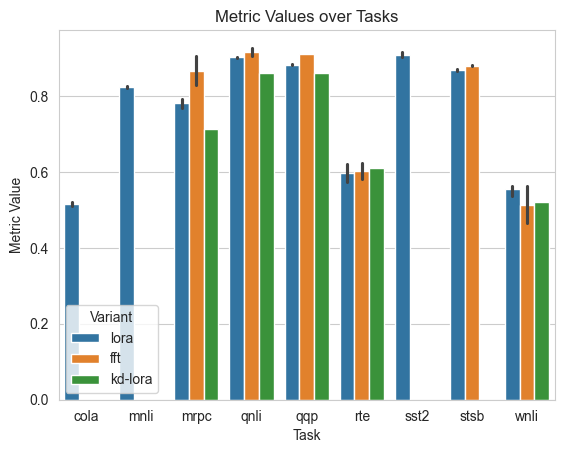

In [80]:
sns.barplot(df, x='Task', y='Metric Value', hue='Variant')
plt.title('Metric Values over Tasks')

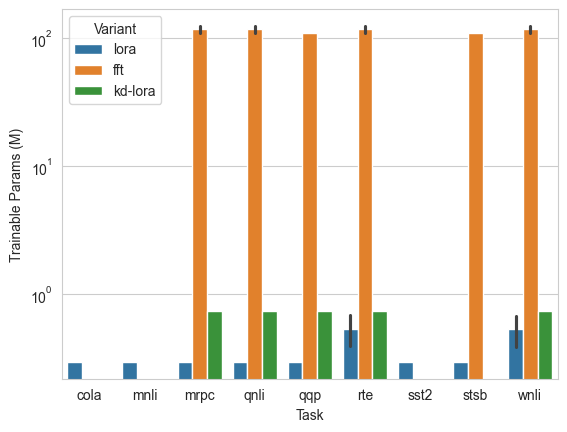

In [73]:
sns.barplot(df, x='Task', y='Trainable Params (M)', hue='Variant')
plt.yscale('log')

<Axes: xlabel='Task', ylabel='Avg GPU Memory (MB)'>

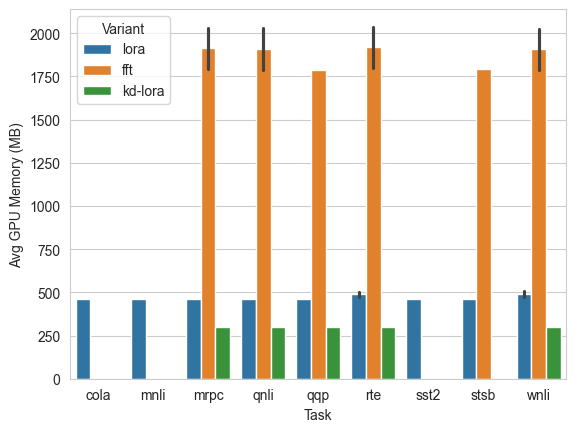

In [74]:
sns.barplot(df, x='Task', y='Avg GPU Memory (MB)', hue='Variant')


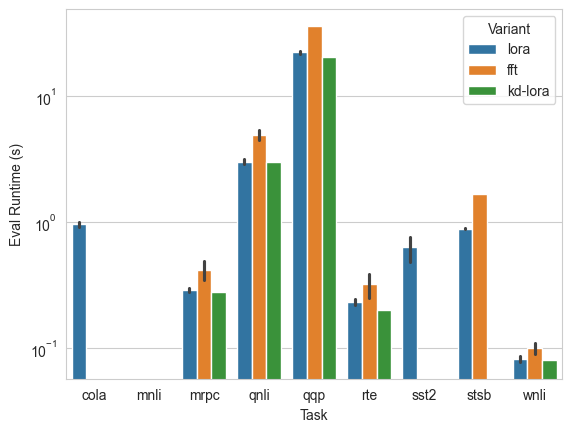

In [75]:
sns.barplot(df, x='Task', y='Eval Runtime (s)', hue='Variant')
plt.yscale('log')

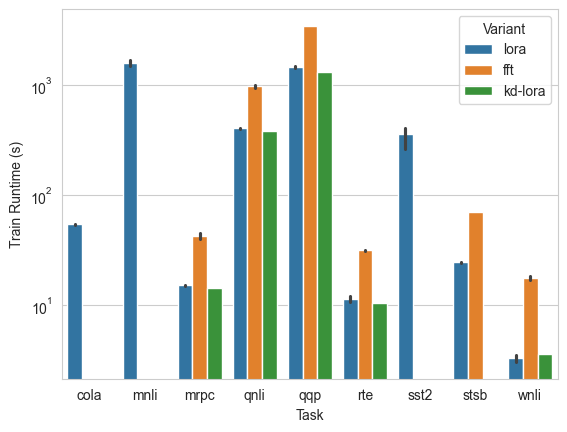

In [76]:
sns.barplot(df, x='Task', y='Train Runtime (s)', hue='Variant')
plt.yscale('log')

In [77]:
data = json.loads(Path('results/lora/task_mnli_bert_42/base_32_5e-05_0.01/peft_lora_16_0.05_8/metrics.json').read_text())

In [78]:
data

{'matched_accuracy': 0.8212939378502292,
 'mismatched_accuracy': 0.8294344995931652,
 'log_history': [{'eval_loss': 0.4972207546234131,
   'eval_accuracy': 0.8008150789607743,
   'eval_runtime': 5.4331,
   'eval_samples_per_second': 1806.524,
   'eval_steps_per_second': 14.172,
   'epoch': 1.0,
   'step': 3068},
  {'eval_loss': 0.463724821805954,
   'eval_accuracy': 0.8184411614875191,
   'eval_runtime': 5.6967,
   'eval_samples_per_second': 1722.928,
   'eval_steps_per_second': 13.517,
   'epoch': 2.0,
   'step': 6136},
  {'eval_loss': 0.4580939710140228,
   'eval_accuracy': 0.8212939378502292,
   'eval_runtime': 5.3958,
   'eval_samples_per_second': 1819.005,
   'eval_steps_per_second': 14.27,
   'epoch': 3.0,
   'step': 9204},
  {'train_runtime': 1506.5037,
   'train_samples_per_second': 782.013,
   'train_steps_per_second': 6.11,
   'total_flos': 3.1105276721076634e+17,
   'train_loss': 0.5221932952894122,
   'epoch': 3.0,
   'step': 9204},
  {'eval_loss': 0.4580939710140228,
   'e

In [79]:
dictor(data, 'log_history')

[{'eval_loss': 0.4972207546234131,
  'eval_accuracy': 0.8008150789607743,
  'eval_runtime': 5.4331,
  'eval_samples_per_second': 1806.524,
  'eval_steps_per_second': 14.172,
  'epoch': 1.0,
  'step': 3068},
 {'eval_loss': 0.463724821805954,
  'eval_accuracy': 0.8184411614875191,
  'eval_runtime': 5.6967,
  'eval_samples_per_second': 1722.928,
  'eval_steps_per_second': 13.517,
  'epoch': 2.0,
  'step': 6136},
 {'eval_loss': 0.4580939710140228,
  'eval_accuracy': 0.8212939378502292,
  'eval_runtime': 5.3958,
  'eval_samples_per_second': 1819.005,
  'eval_steps_per_second': 14.27,
  'epoch': 3.0,
  'step': 9204},
 {'train_runtime': 1506.5037,
  'train_samples_per_second': 782.013,
  'train_steps_per_second': 6.11,
  'total_flos': 3.1105276721076634e+17,
  'train_loss': 0.5221932952894122,
  'epoch': 3.0,
  'step': 9204},
 {'eval_loss': 0.4580939710140228,
  'eval_accuracy': 0.8212939378502292,
  'eval_runtime': 5.3332,
  'eval_samples_per_second': 1840.347,
  'eval_steps_per_second': 14.